
<h1 align="center">I. Introduction </h1>


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Ce notebook vient à la suite du fichier exploration_globale.ipynb qui contient un jeu de données correspondant au challenge Rakuten et qui a pour objectif de prédire un code produit à partir de <b>données textuelles</b>.

Après avoir nettoyé, analysé  et compris le jeu de données Rakuten, l'objectif est de construire des modèles de classification capables de prédire "prdtypecode" à partir des features créées.

Plusieurs modèles de classifications ont été réalisés et testés dans l'espoir d'obtenir un résultat favorable à l'adoption du modèle. Ceux développés dans ce notebook ont obtenus les meilleurs résultats.
</div>



In [1]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
df = pd.read_csv("rakuten_features_v1.csv")

In [3]:
df.head(2)

,prdtypecode,category,designation_cleaned,description_cleaned,text_clean,dup_count,is_duplicated_group,nb_digits_text,has_any_unit,contains_numerotation,...,Jouets & Figurines_keywords,Loisirs & Plein air_keywords,Modélisme & Drones_keywords,Littérature_keywords,Livres spécialisés_keywords,Presse & Magazines_keywords,Séries & Encyclopédies_keywords,Décoration & Lumières_keywords,Textiles d'intérieur_keywords,Équipement Maison_keywords
0,2280,Presse & Magazines,journal arts (le) n° 133 28/09/2001 l'art marc...,NaN,journal arts (le) n° 133 28/09/2001 l'art marc...,1,False,11,1,True,...,0,0,0,0,3,1,0,0,0,0
1,50,Accessoires,stylet ergonomique bleu gamepad nintendo wii s...,pilot style touch pen marque speedlink stylet ...,stylet ergonomique bleu gamepad nintendo wii s...,1,False,4,0,False,...,0,0,0,0,1,0,3,1,0,0


In [4]:
df["category"].head(27)

0           Presse & Magazines
1                  Accessoires
2                  Littérature
3           Presse & Magazines
4           Bureau & Papeterie
5            Équipement Jardin
6            Équipement Maison
7         Textiles d'intérieur
8            Équipement Maison
9           Bureau & Papeterie
10      Séries & Encyclopédies
11          Presse & Magazines
12                     Piscine
13    Jeux de rôle & Figurines
14                   Figurines
15          Modélisme & Drones
16         Jeux Vidéo Modernes
17          Jouets & Figurines
18          Bureau & Papeterie
19          Presse & Magazines
20              Jeux de cartes
21       Décoration & Lumières
22           Équipement Maison
23       Décoration & Lumières
24              Jeux éducatifs
25        Textiles d'intérieur
26                     Piscine
Name: category, dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64576 entries, 0 to 64575
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   prdtypecode                              64576 non-null  int64 
 1   category                                 64576 non-null  object
 2   designation_cleaned                      64574 non-null  object
 3   description_cleaned                      49213 non-null  object
 4   text_clean                               64576 non-null  object
 5   dup_count                                64576 non-null  int64 
 6   is_duplicated_group                      64576 non-null  bool  
 7   nb_digits_text                           64576 non-null  int64 
 8   has_any_unit                             64576 non-null  int64 
 9   contains_numerotation                    64576 non-null  bool  
 10  Animaux_keywords                         64576 non-null  i

Ce jeu de données contient:
- la cible de la classification:"prdtypecode",
- le texte nettoyé: text_clean, designation_cleaned, description_cleaned,
- des indicateurs de doublons : dup_count, is_duplicated_group,
- des informations liées aux catégories : category, 
- des features : nb_digits_text, has_any_unit, contains_numerotation,
- des colonnes de mots-clés par univers.

<h1 align="center">II. Préparation Et Modélisation Des Données </h1>


<div style="background:#f0f8ff; padding:12px; border-radius:6px"><h2 align="center"> 2.1 Première modélisation supervisée à partir des features "_keywords"</h2></div>

Dans quelle mesure les keywords permettent-ils réellement de prédire la catégorie d’un produit ?

Nous passons de l’exploration descriptive à la modélisation prédictive afin de tester la robustesse de notre travail de structuration lexicale.
Nous entraînons un modèle simple, une régression logistique multinomiale, adaptée à un problème de classification multi-classes (ici 27 classes).
Le solver choisi est saga, performant pour des datasets de grande taille et compatible avec la régularisation.
La pondération des classes est réglée sur balanced afin de compenser le déséquilibre entre les différentes classes, ce qui évite que le modèle sur-prévoie systématiquement les classes majoritaires.

Préparation des données : X contient toutes les colonnes _keywords, représentant la fréquence des mots clés dans le texte du produit.
y correspond à la variable cible prdtypecode.

Les données sont séparées en ensemble d’entraînement (85%) et ensemble de test (15%), en conservant la proportion de chaque classe avec stratify=y.

Pour l'entraînement et prédiction, le modèle apprend à associer la fréquence des mots-clés à la catégorie de produit. Ensuite, nous faisons des prédictions sur l’ensemble de test pour mesurer la capacité du modèle à généraliser à des données jamais vues.

In [ ]:


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score


# Les features sont les colonnes _keywords générées dans new_X
keyword_cols = [c for c in df.columns if c.endswith("_keywords")]
X = df[keyword_cols]          
y = df["prdtypecode"]         
print("Shape de X:", X.shape)
print("Nombre de classes dans y:", y.nunique())

# On utilise 85% des données pour l'entraînement et 15% pour le test,
# en conservant la proportion des classes avec stratify.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

model = LogisticRegression(
    solver="saga",
    class_weight="balanced",
    max_iter=2000,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# --- Alias pour réutilisation plus tard dans le notebook ---
log_reg = model
X_train_kw, X_test_kw, y_train_kw, y_test_kw = X_train, X_test, y_train, y_test
y_pred_kw = y_pred

f1_weighted_keywords = f1_score(y_test_kw, y_pred_kw, average='weighted')
print('F1-weighted (keywords, LogReg):', round(f1_weighted_keywords, 4))

print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification report:\n", classification_report(y_test, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatrice de confusion:\n", conf_matrix)

# Identification des colonnes _keywords les plus influentes
feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_[0]  # pour la première classe
}).sort_values(by="coef", ascending=False)

print("\nTop 10 features influentes:")
print(feature_importance.head(10))

Shape de X: (64576, 27)
Nombre de classes dans y: 27


C:\Users\celin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
C:\Users\celin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1-weighted (keywords, LogReg): 0.5322
Accuracy: 0.5124393517084753

Classification report:
               precision    recall  f1-score   support

          10       0.12      0.67      0.21       232
          40       0.40      0.28      0.33       167
          50       0.45      0.47      0.46       182
          60       0.75      0.83      0.79       104
        1140       0.51      0.67      0.58       145
        1160       0.77      0.70      0.74       227
        1180       0.14      0.37      0.20        52
        1280       0.56      0.26      0.35       525
        1281       0.26      0.26      0.26       219
        1300       0.73      0.72      0.73       535
        1301       0.29      0.56      0.39       110
        1302       0.60      0.51      0.55       330
        1320       0.42      0.38      0.40       382
        1560       0.59      0.43      0.50       699
        1920       0.82      0.75      0.78       617
        1940       0.16      0.51      0.2

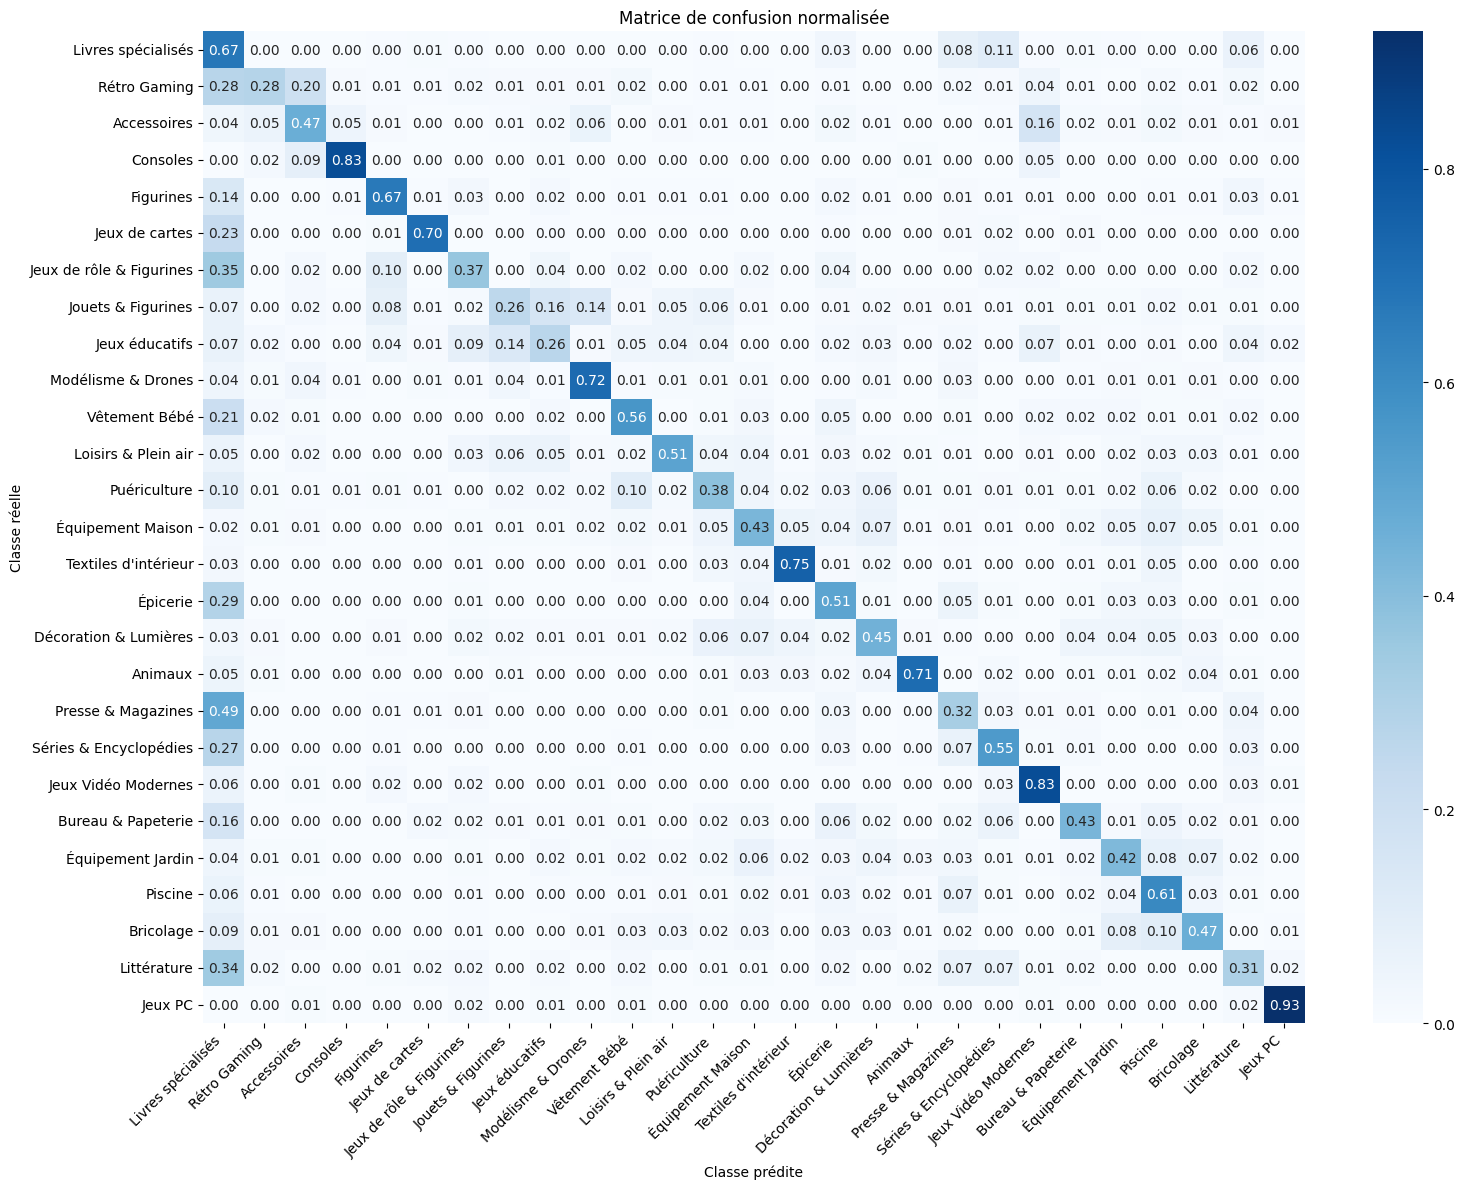


Nombre d'échantillons par classe (réel vs prédit):
                          Réel  Prédit
Livres spécialisés         232    1279
Rétro Gaming               167     117
Accessoires                182     191
Consoles                   104     114
Figurines                  145     189
Jeux de cartes             227     207
Jeux de rôle & Figurines    52     138
Jouets & Figurines         525     241
Jeux éducatifs             219     227
Modélisme & Drones         535     528
Vêtement Bébé              110     211
Loisirs & Plein air        330     279
Puériculture               382     352
Équipement Maison          699     507
Textiles d'intérieur       617     566
Épicerie                    97     305
Décoration & Lumières      694     497
Animaux                    111     140
Presse & Magazines         493     424
Séries & Encyclopédies     468     406
Jeux Vidéo Modernes        109     189
Bureau & Papeterie         632     408
Équipement Jardin          290     309
Piscine     

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

code_to_cat = (
    df[["prdtypecode", "category"]]
    .dropna()
    .groupby("prdtypecode")["category"]
    .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    .to_dict()
)

labels = np.sort(np.unique(np.concatenate([y_test_kw, y_pred_kw])))

label_names = [code_to_cat.get(l, str(l)) for l in labels]

cm = confusion_matrix(y_test_kw, y_pred_kw, labels=labels)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(16, 12))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title("Matrice de confusion normalisée")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

y_test_counts = pd.Series(y_test_kw).value_counts().reindex(labels, fill_value=0)
y_pred_counts = pd.Series(y_pred_kw).value_counts().reindex(labels, fill_value=0)

df_counts = pd.DataFrame({"Réel": y_test_counts, "Prédit": y_pred_counts})
df_counts.index = label_names  # index = noms des catégories

print("\nNombre d'échantillons par classe (réel vs prédit):")
print(df_counts)


**Résultats obtenus pour notre modèle** 

Le modèle de régression logistique multiclasse obtient une accuracy globale 
d’environ 0,51, ce qui signifie qu’il parvient à prédire correctement un peu plus d'une observation sur deux.

La balanced accuracy (≈ 0,53) et le F1-score macro (≈ 0,50) confirment une performance modérée avec un effet persistant du déséquilibre entre classes (le F1 pondéré est ≈ 0,53).

Le rapport de classification montre que :

- certaines classes obtiennent de bons scores, par exemple 2583 (F1 ≈ 0,68), 1920 (F1 ≈ 0,78), 1300 (F1 ≈ 0,73) ;

- d’autres classes rares ou plus difficiles à distinguer présentent des performances faibles, par exemple 10 (F1 ≈ 0,21), 1180 (F1 ≈ 0,20), 1940 (F1 ≈ 0,24).

La matrice de confusion met en évidence de nombreux transferts vers quelques classes dominantes, signe que le modèle tend à sur-prédire les classes les plus fréquentes.

Enfin, l’analyse des coefficients révèle que certains groupes de mots-clés jouent un rôle déterminant, notamment Littérature_keywords (coef ≈ 1,76), Presse & Magazines_keywords (≈ 1,23) et Bureau & Papeterie_keywords (≈ 0,32).

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">2.2 RandomForest Sur Les Features Liées à La Présence De Chiffres Et D'Unités</h2>

La première baseline est construite à partir de quelques features générées liées au nombre de chiffres, à la présence d’unités ou encore à la  présence de numéros dans le texte. Le modèle choisi est celui du RandomForest, l'ensemble des données d'entrée est donc numérique.

In [8]:
# Création des dummies pour "contains_numerotation" qui est un boolean
dummies = pd.get_dummies(df['contains_numerotation'], prefix='numerotation_in')

df = df.drop(columns=['contains_numerotation'])

df = df.join(dummies)

cols= ([
    "has_any_unit",
    "nb_digits_text",
    "numerotation_in_False",
    "numerotation_in_True",
])

data = df[cols].copy()


In [9]:
target=df['prdtypecode']


a) Création d'un ensemble d'entraînement et d'un ensemble de test

Nous séparons les datasets en un jeu d'apprentissage et un jeu de test. La taille du jeu de test correspondra à 15% de la quantité totale des données disponible. Nous choississons un random_state égal à 42. 

In [10]:
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    data,
    target,
    test_size=0.15,
    random_state=42,
    stratify=target,
)


b) Apprentissage des données

In [11]:
# Modèle RandomForest (features chiffres + unités uniquement)
rf_num = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=321,
)
rf_num.fit(X_train_num, y_train_num)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [12]:
# Prédiction sur l'ensemble de test (modèle "4 num")
y_pred_num = rf_num.predict(X_test_num)


c) Matrice de confusion de l'échantillon de test

In [13]:
pd.crosstab(
    y_test_num,
    y_pred_num,
    rownames=['Classe réelle'],
    colnames=['Classe prédite']
)


Classe prédite,10,50,60,1140,1160,1180,1280,1300,1301,1302,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
Classe réelle,,,,,,,,,,,,,,,,,,,,,
10,0,2,6,1,28,0,0,0,1,0,...,0,14,9,3,0,0,0,0,165,2
40,0,2,4,1,20,3,0,1,3,0,...,1,0,10,10,5,5,1,0,73,2
50,0,2,13,3,40,0,0,0,3,0,...,5,0,11,6,5,10,1,2,51,7
60,0,0,17,4,12,2,0,0,6,0,...,1,0,3,1,7,3,0,1,10,5
1140,0,0,4,17,16,0,0,0,1,0,...,1,9,11,2,9,1,0,1,55,0
1160,0,0,18,0,125,0,0,0,0,0,...,0,10,11,13,0,2,0,0,39,5
1180,0,0,1,1,7,0,0,0,0,0,...,0,0,1,1,3,3,0,0,33,0
1280,0,1,32,34,50,3,1,11,28,0,...,21,1,6,7,25,21,13,9,82,24
1281,0,0,9,18,45,0,0,2,9,0,...,2,2,12,2,11,2,0,1,53,1


In [14]:
y_test_num_names = pd.Series(y_test_num).map(code_to_cat).fillna(pd.Series(y_test_num).astype(str))
y_pred_num_names = pd.Series(y_pred_num).map(code_to_cat).fillna(pd.Series(y_pred_num).astype(str))

pd.crosstab(
    y_test_num_names,
    y_pred_num_names,
    rownames=["Classe réelle"],
    colnames=["Classe prédite"]
)

Classe prédite,Accessoires,Animaux,Bricolage,Bureau & Papeterie,Consoles,Décoration & Lumières,Figurines,Jeux PC,Jeux Vidéo Modernes,Jeux de cartes,...,Modélisme & Drones,Piscine,Presse & Magazines,Puériculture,Séries & Encyclopédies,Textiles d'intérieur,Vêtement Bébé,Épicerie,Équipement Jardin,Équipement Maison
Classe réelle,,,,,,,,,,,,,,,,,,,,,
Accessoires,0,0,0,2,6,1,0,1,0,4,...,1,0,1,2,0,5,1,1,1,2
Animaux,0,0,0,0,1,0,1,0,1,2,...,0,0,0,1,0,2,2,1,2,0
Bricolage,0,1,2,5,4,2,0,1,0,3,...,0,1,4,1,1,7,2,1,6,3
Bureau & Papeterie,0,3,1,3,6,3,4,3,0,6,...,0,3,9,2,1,11,4,6,4,3
Consoles,0,0,1,0,1,0,0,2,0,1,...,1,1,1,0,0,2,1,2,0,0
Décoration & Lumières,0,2,5,7,6,2,4,6,1,7,...,3,1,6,1,5,18,4,3,5,4
Figurines,1,0,0,3,1,0,0,0,0,1,...,1,0,2,0,2,2,1,0,0,0
Jeux PC,1,0,1,0,0,0,0,0,0,0,...,1,0,0,1,2,1,2,0,2,1
Jeux Vidéo Modernes,0,0,0,3,2,0,1,0,0,0,...,0,1,1,0,0,3,0,2,1,0


Nous remarquons que la diagonale est plutôt forte, le modèle arrive souvent à prédire correctement la bonne catégorie. Le modèle a détecté 1439 bonnes réponses pour le prdtypecode n°2583 par exemple. Cependant, certaines classes sont souvent confondues entre elles. Par exemple, les prdtypecodes n° 10, 40 et 50 se mélangent régulièrement, ce qui suggère que leurs descriptions produits sont proches.

In [15]:
acc_num = rf_num.score(X_test_num, y_test_num)
print("Accuracy (4 num) :", round(acc_num, 4))


Accuracy (4 num) : 0.1801


In [16]:
y_probas_num = rf_num.predict_proba(X_test_num)


In [17]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score

acc_num = accuracy_score(y_test_num, y_pred_num)
f1_weighted_num = f1_score(y_test_num, y_pred_num, average="weighted")

print("Accuracy:", round(acc_num, 4))
print("F1-weighted:", round(f1_weighted_num, 4))


Accuracy: 0.1801
F1-weighted: 0.1585


d) Rapport de Classification

In [18]:
target_names = [code_to_cat.get(l, str(l)) for l in labels]
print(
    classification_report(
        y_test_num,
        y_pred_num,
        labels=labels,
        target_names=target_names,
        zero_division=0
    ))

                          precision    recall  f1-score   support

      Livres spécialisés       0.00      0.00      0.00       232
            Rétro Gaming       0.00      0.00      0.00       167
             Accessoires       0.04      0.01      0.02       182
                Consoles       0.04      0.16      0.06       104
               Figurines       0.06      0.12      0.08       145
          Jeux de cartes       0.14      0.55      0.22       227
Jeux de rôle & Figurines       0.00      0.00      0.00        52
      Jouets & Figurines       0.12      0.00      0.00       525
          Jeux éducatifs       0.00      0.00      0.00       219
      Modélisme & Drones       0.24      0.08      0.12       535
           Vêtement Bébé       0.03      0.11      0.05       110
     Loisirs & Plein air       0.00      0.00      0.00       330
            Puériculture       0.09      0.03      0.04       382
       Équipement Maison       0.16      0.07      0.10       699
    Texti

Le modèle atteint une accuracy de 0,18, avec un F1-score pondéré de 0,16.
Une grande partie des classes ont des scores nuls, ce qui signifie qu’elles sont rarement voire jamais prédites correctement (ex. Livres spécialisés, Rétro Gaming, Jeux éducatifs).
Par contre, la catégorie Press & Magazine est très bien reconnue (F1= 0,81) .


e) Barplot des performances par classe

F1-weighted global  : 0.1585


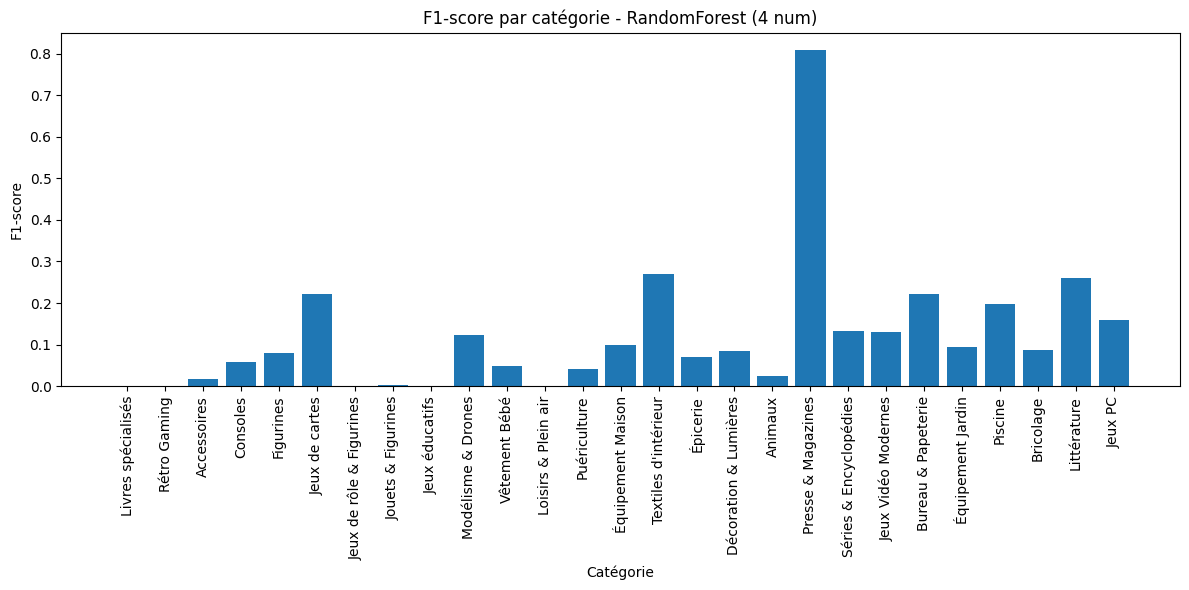

In [19]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd

f1_weighted_num = f1_score(y_test_num, y_pred_num, average="weighted")
print("F1-weighted global  :", round(f1_weighted_num, 4))

labels_codes = sorted(list(set(y_test_num)))

f1_per_class = f1_score(
    y_test_num,
    y_pred_num,
    labels=labels_codes,
    average=None
)

# création du dictionnaire code -> nom de catégorie
code2cat = (
    df[["prdtypecode", "category"]]
    .drop_duplicates("prdtypecode")
    .set_index("prdtypecode")["category"]
    .to_dict()
)

# liste des noms de catégories dans le même ordre que labels_codes
category_names = [code2cat.get(code, str(code)) for code in labels_codes]


plt.figure(figsize=(12, 6))
plt.bar(range(len(labels_codes)), f1_per_class)
plt.xticks(range(len(labels_codes)), category_names, rotation=90)
plt.xlabel("Catégorie")
plt.ylabel("F1-score")
plt.title("F1-score par catégorie - RandomForest (4 num)")
plt.tight_layout()
plt.show()


Nous constatons que la plupart des catégories sont mal discriminées avec des F1-scores proches de 0. Seule la catégorie "Presse&Magazine" ressort nettement.

En conclusion,la présence de chiffres et d’unités fournit un signal utile pour quelques catégories cependant, ces features seules sont insuffisantes pour discriminer les catégories.


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">2.2 RandomForest Sur L'ensemble Des Features</h2>

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd



keyword_cols = [c for c in df.columns if c.endswith("_keywords")]


base_num_cols = [
    "nb_digits_text",       
    "has_any_unit",
    "numerotation_in_False",
    "numerotation_in_True",
]


feature_cols = base_num_cols + keyword_cols

# X = features, y = cible
X = df[feature_cols].copy()
y = df["prdtypecode"]


bool_cols = ["has_any_unit", "numerotation_in_False", "numerotation_in_True"]

for col in bool_cols:
    if col in X.columns:
        X[col] = X[col].astype(int)


X = X.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)

print("Shape X :", X.shape)



X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

print("Shapes train / test :", X_train.shape, X_test.shape)



Shape X : (64576, 31)
Shapes train / test : (54889, 31) (9687, 31)


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

rf_all = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=321,
)

rf_all.fit(X_train, y_train)

y_pred_all = rf_all.predict(X_test)

acc_all = accuracy_score(y_test, y_pred_all)
f1_weighted_all = f1_score(y_test, y_pred_all, average="weighted")

print("RandomForest (toutes features) - Accuracy :", round(acc_all, 4))
print("RandomForest (toutes features) - F1-weighted :", round(f1_weighted_all, 4))


RandomForest (toutes features) - Accuracy : 0.6555
RandomForest (toutes features) - F1-weighted : 0.6612


Avec le RandomForest entraîné sur l’ensemble des features, on obtient un F1-score pondéré de 0,66. 
Nous obtenons une amélioration nette du résultat par rapport aux modèles basés uniquement sur les chiffres et unités. 
La combinaison des signaux (mots-clés + valeurs numériques) permet au modèle de mieux discriminer les catégories.

<h1 align="center">III. Analyse des résultats </h1>


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">3.1 Importance globale des features</h2>

Top 20 des features les plus importantes :
                                    feature  importance
5                        Figurines_keywords    0.897738
11     Accessoires & Périphériques_keywords    0.861109
20                     Littérature_keywords    0.820386
2                         Épicerie_keywords    0.789894
3                     Puériculture_keywords    0.789104
4          Vêtement Bébé & Loisirs_keywords    0.751957
25            Textiles d'intérieur_keywords    0.750928
22              Presse & Magazines_keywords    0.747769
14             Jeux Vidéo Modernes_keywords    0.711246
7         Jeux de rôle & Figurines_keywords    0.696290
8            Bricolage & Outillage_keywords    0.668975
1               Bureau & Papeterie_keywords    0.666547
6                   Jeux de cartes_keywords    0.643276
9   Décoration & Équipement Jardin_keywords    0.603877
18             Loisirs & Plein air_keywords    0.591692
24           Décoration & Lumières_keywords    0.577570
26   

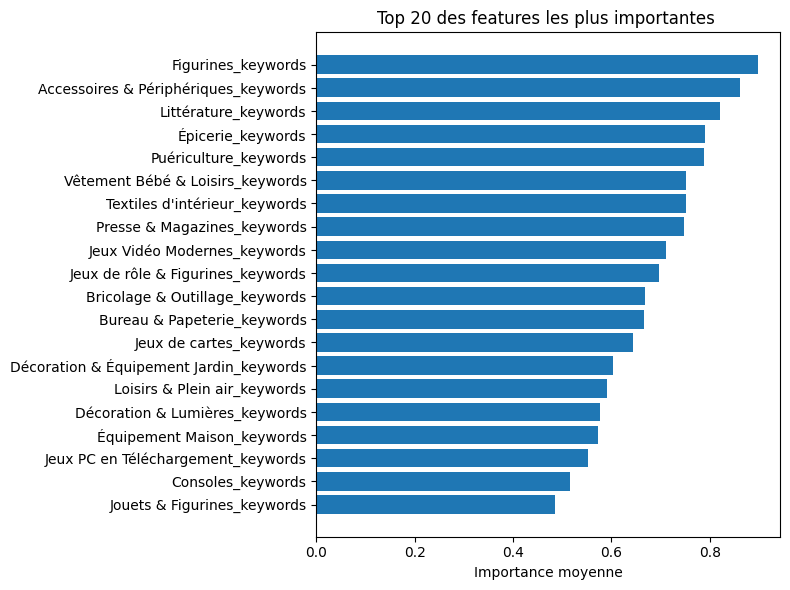

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


try:
    feature_names = X_train_kw.columns
except NameError:
    feature_names = X.columns


coef = (log_reg.coef_ if 'log_reg' in globals() else model.coef_)  

# importance globale = moyenne de coef pour chaque feature
importance = np.mean(np.abs(coef), axis=0)


feature_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
})


feature_importance = feature_importance.sort_values("importance", ascending=False)
print("Top 20 des features les plus importantes :")
print(feature_importance.head(20))


top_n = 20
top_feats = feature_importance.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance moyenne")
plt.title("Top 20 des features les plus importantes ")
plt.tight_layout()
plt.show()


Nous avons basé l'importance des features sur la moyenne des coefficients de toutes les classes. </n>
Les features les plus fortes sont des mots-clés permettant de distinguer précisement des catégories.</n>
Effectivement, la performance du modèle dépend beaucoup de la liste des mots-clés (_keywords).

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">3.2 Importance des features pour une classe spécifique</h2>

In [23]:
def plot_top_features_for_class(class_code, top_n=15):
    """
    Affiche les top_n features les plus importantes pour une classe donnée
    (prdtypecode) .
    """
    classes = log_reg.classes_
    
    if class_code not in classes:
        print(f"Classe {class_code} absente du modèle.")
        return
    
    idx = np.where(classes == class_code)[0][0]
    
    coefs_class = log_reg.coef_[idx]  

    df_imp = pd.DataFrame({
        "feature": X_train_kw.columns,  
        "coef": coefs_class,
        "abs_coef": np.abs(coefs_class)
    })

    df_imp = df_imp.sort_values("abs_coef", ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    plt.barh(df_imp["feature"], df_imp["coef"])
    plt.gca().invert_yaxis()  
    plt.axvline(0, color="black", linewidth=1)

    titre_cat = code2cat.get(class_code, str(class_code))
    plt.title(f"Top {top_n} features pour la classe {class_code} - {titre_cat}")
    plt.xlabel("Coefficient (positif = favorise la classe)")
    plt.tight_layout()
    plt.show()


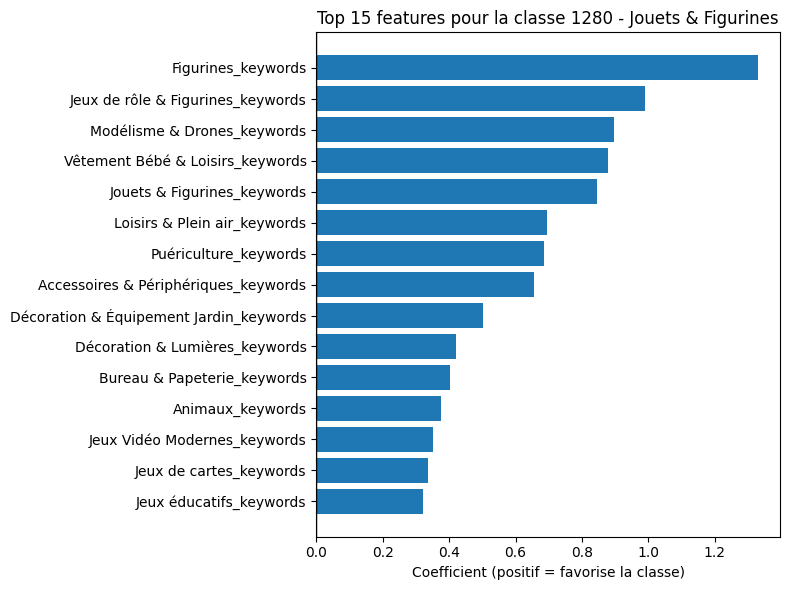

In [24]:
plot_top_features_for_class(1280, top_n=15)


Nous constatons que lpour la classe Jouets & Figurine, les variables les plus explicatives sont celles directement liées au champs lexical des figurines. La présence de ces mots-clés augmente donc fortement la probabilité d'un produit soint classé en 1280.

L' importance des features confirme que la performance du modèle repose surtout sur des mots-clés et que des erreurs peuvent provenir de catégories voisines partageant des termes similaires (exemple "Vêtement Bébé & Loisirs_keywords").

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">3.3 Comparaison des modèles</h2>

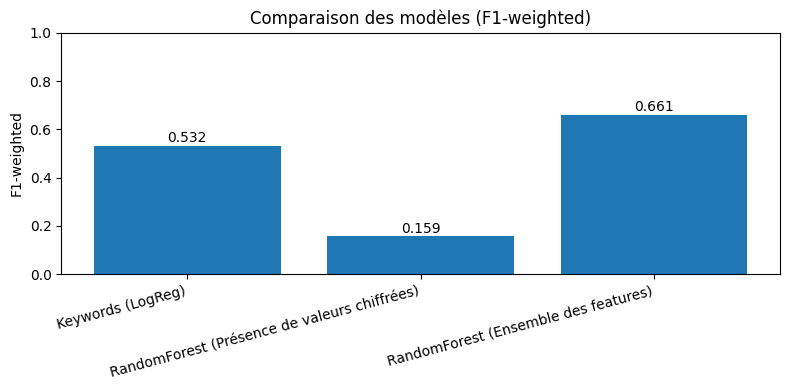

,Modèle,F1_weighted
0,Keywords (LogReg),0.532220
1,RandomForest (Présence de valeurs chiffrées),0.158517
2,RandomForest (Ensemble des features),0.661172


In [25]:

best_name = "RandomForest (toutes features)"
y_pred_best = y_pred_all
best_model = rf_all


results = pd.DataFrame({
    "Modèle": [
        "Keywords (LogReg)",
        "RandomForest (Présence de valeurs chiffrées)",
        "RandomForest (Ensemble des features)"
    ],
    "F1_weighted": [
        f1_weighted_keywords,
        f1_weighted_num,
        f1_weighted_all
    ]
})

plt.figure(figsize=(8, 4))
plt.bar(results["Modèle"], results["F1_weighted"])

for i, v in enumerate(results["F1_weighted"]):
    plt.text(i, v + 0.001, f"{v:.3f}", ha="center", va="bottom")

plt.ylim(0, 1)
plt.ylabel("F1-weighted")
plt.title("Comparaison des modèles (F1-weighted)")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

results


La comparaison des trois approches montre que le RandomForest utilisant toutes les features est le modèle le plus performant, avec un F1-score pondéré ≈ 0,66. 

Le modèle de régression logistique basé uniquement sur les keywords obtient des résultats intermédiaires, ce qui confirme que les mots-clés capturent déjà une partie importante du signal, mais restent insuffisants seuls. 

Le RandomForest basé uniquement sur les chiffres et les unités obtient des résulats très bas (F1-weighted ≈ 0,16) ce qui indique que ces features seules, ne permettent pas de discriminer correctement les catégories. 

La meilleure stratégie est donc de combiner toutes les features.